In [1]:
"""
Install virtual enviroment outside project folder.
In command line enter:
python3 -m venv multimodal
pip install ipykernel
python3 -m ipykernel install --user --name=multimodal
Start `Jupyter Lab` at /Multimodal-Deep-Regression/notebooks
Select `multimodal` kernel in right upper corner.
"""
# !pip install -r ../requirements.txt

'\nInstall virtual enviroment outside project folder.\nIn command line enter:\npython3 -m venv multimodal\npip install ipykernel\npython3 -m ipykernel install --user --name=multimodal\nStart `Jupyter Lab` at /Multimodal-Deep-Regression/notebooks\nSelect `multimodal` kernel in right upper corner.\n'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import random
import time
import whisper
import numpy
import warnings

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import get_base_tensor_directories, generate_batch, process_data, add_ae_tensor, get_ensemble_data, generate_batch_ensemble, generate_autoencoder_batch
from util.audio_utilities import extract_embeddings, extract_audio

import torch.optim.lr_scheduler as lr_scheduler

In [2]:
# Preprocessing paramemter & ConvLSTMAutoencoder
DEVICE = 'cpu' # get_device() # CPU or GPU 
DATASET = 'video_pack_1000'
FRAME_SKIP = 200 # how many frame to skip, reduce depth
SHRINK = 8 # shrink the scale (H x W)//N
NORMALIZE = False # normalize the pixel to 0 to 1
PAD_ALL = False # pad all tensors with max depth
BATCH_SIZE = 15

EXTRACT_DATA = False # Set whether to run cells that extract data

autoencoder_load = True

In [3]:
# ConvLSTMAutoencoder Hyper-Parameters
LEARNING_RATE = 1e-4
EPOCHS = 10
HIDDEN_SIZE = 64 # ConvLSTMAutoencoder hidden size

In [4]:
# Transformer Visual & Audio Hyper-Parameters
NUM_HEADS = 8 # number of attenion heads
HIDDEN_DIM = 256 # Transformer hidden size
NUM_LAYERS = 6 # number of Transformer layers

# EnsembleModel Hyper-Parameters
LEARNING = 1e-3
THE_EPOCHS = 10
AUDIO_TRANSFORMER = True # if False, will skip audio transfomer part 
LATE_FUSION = True # early fusion or late fusion #NOT WORKING YET

In [6]:
if EXTRACT_DATA:
    # extract audio from video dataset
    extract_audio(f"../data/video_packs/{DATASET}/", f"../data/audio/{DATASET}")

    # using whipser to transcribe audio dialog & extract LLMs embedding
    extract_embeddings(audio_file_path=f"../data/audio/{DATASET}", output_dir="../data/audio_embeddings/", device=DEVICE)

In [7]:
if EXTRACT_DATA:
    # disable pyav warning
    warnings.filterwarnings("ignore", message="Accurate seek is not implemented for pyav backend")

    # video visual processing
    process_data(
        input_type=DATASET, 
        #addition_parameters={'first_n_videos': 10}, 
        verbose=False,
        device=get_device(),
        frames_to_skip=FRAME_SKIP,
        shrink=SHRINK,
        normalize=NORMALIZE
        )

In [8]:
x_dir, y_dir = get_base_tensor_directories(input_type=DATASET)

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)]) 
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])

if not autoencoder_load:
    # load all visual tensors
    x_data = [torch.load(f) for f in x_files] 
    y_data = [torch.load(f) for f in y_files] 

    # split the data
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
    print(x_train[0].size())
    print(x_val[0].size())
    print(len(y_train))
    print(len(y_val))

    

In [9]:
if not autoencoder_load:
    # Create AutoEncoder Batches with DataLoaders
    batch_size = BATCH_SIZE
    train_loader = list(zip(x_train, x_train))
    val_loader = list(zip(x_val, x_val))
    train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_autoencoder_batch)
    val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_autoencoder_batch)

    # check size Batch, Channel, Frame, Height, Width
    data, targets = next(iter(train_loader))
    data.size(), targets.size()

In [12]:
from models import ConvLSTMAutoencoder

autoencoder = ConvLSTMAutoencoder(hidden_dim=HIDDEN_SIZE, shrink=SHRINK, normalize=NORMALIZE)
autoencoder = autoencoder.to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

Total parameters: 1,041,859


In [13]:
ECHO = 1 # print in N epoch only when training
SAVE_NAME = 'ConvLSTMAutoencoder_hidden6222_weights.pt' # save the weights

In [14]:
# load check point
if autoencoder_load:
    weights_file = f'../models/save/{SAVE_NAME}'
    autoencoder.load_state_dict(torch.load(weights_file)['model_state_dict'])
    train_losses = torch.load(weights_file)['train_losses']
    val_losses = torch.load(weights_file)['val_losses']

In [13]:
if not autoencoder_load:
    start_time = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        train_loss, avg_train_loss = train(autoencoder, train_loader, criterion, optimizer, DEVICE)
        val_loss, avg_val_loss = evaluate(autoencoder, val_loader, criterion, DEVICE)
        
        # record the losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # print every num times epoch only
        echo = ECHO
        if ((epoch+1) % echo == 0) or epoch == 0:
            if epoch == 0:
                time_took = (time.time() - start_time) / 60
                print(f'First epoch took {time_took:.1f} minutes.')
            print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')

In [14]:
if not autoencoder_load:
    # save model if better or not exists
    model_weights = {'model_state_dict': autoencoder.state_dict(), 'val_loss': avg_train_loss, 'train_losses':train_losses, 'val_losses':val_losses}
    weights_file = f'../models/save/{SAVE_NAME}'
    if not os.path.isfile(weights_file):
        # save new
        torch.save(model_weights, weights_file)
        print('save new model')
    elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
        # replace
        torch.save(model_weights, weights_file)
        print('replace old model')
    else:
        print('old model perform better')

In [15]:
if not autoencoder_load:
    # loss plot
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [16]:
if not autoencoder_load:
    # Random sample inspection
    random_num = random.randint(0, len(val_loader)-1)

    for i, (inputs, targets) in enumerate(val_loader):
        if i == random_num:  # random sample
            inputs, targets = inputs.to(torch.float32).to(DEVICE), targets.to(torch.float32).to(DEVICE)
            outputs = autoencoder(inputs).detach()
            break

            
    # Actual
    print('Actual:')
    for i in range(3):
        # select first 3 frame
        image_tensor = targets.squeeze()[0,:,i,:,:]
        print(image_tensor.size())
        numpy_image = image_tensor.detach().numpy()

        # imshow (Height, Width, Channels)
        numpy_image = numpy_image.transpose((1, 2, 0))

        # normalize to 0,1
        numpy_image = (numpy_image - numpy_image.min()) / (numpy_image.max() - numpy_image.min())

        plt.imshow(numpy_image)
        plt.show()
        
    # AutoEncoder
    print('AutoEncoder:')
    for i in range(3):
        # select first 3 frame
        image_tensor = outputs.squeeze()[0,:,i,:,:]
        numpy_image = image_tensor.detach().numpy()

        # imshow (Height, Width, Channels)
        numpy_image = numpy_image.transpose((1, 2, 0))

        # normalize to 0,1
        numpy_image = (numpy_image - numpy_image.min()) / (numpy_image.max() - numpy_image.min())

        plt.imshow(numpy_image)
        plt.show()

In [17]:
# load ensemble data
x_data, y_data = get_ensemble_data(x_files, DATASET)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)

In [18]:
import pandas as pd
import numpy as np

In [19]:
y_train_raw = np.array([i.item() for i in y_train])
df_describe = pd.DataFrame(y_train_raw)
df_describe.describe()

,0
count,800.000000
mean,7260.918375
std,20648.766175
min,10.600000
25%,403.599998
50%,2100.000000
75%,7500.500000
max,373000.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

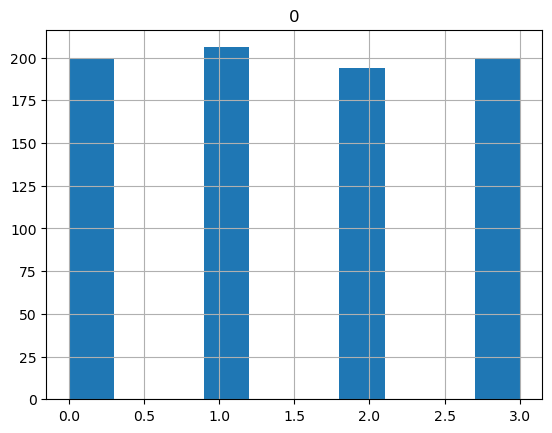

In [20]:
y_train_encoded = np.where(
    y_train_raw <= 403.599998,
    0,
    np.where(
        y_train_raw <= 2100.000000,
        1,
        np.where(
            y_train_raw <= 7500.500000,
            2,
            3
        )
    )
)
df_describe2 = pd.DataFrame(y_train_encoded)
df_describe2.hist()

In [21]:
y_train_encoded[:9]

array([0, 1, 1, 3, 0, 0, 2, 1, 3])

array([[<Axes: title={'center': '0'}>]], dtype=object)

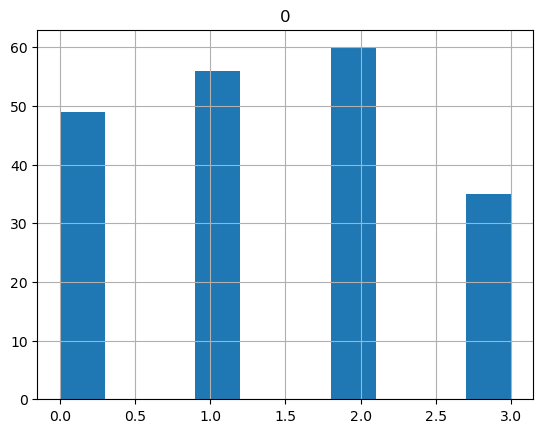

In [22]:
y_val_raw = np.array([i.item() for i in y_val])
y_val_encoded = np.where(
    y_val_raw <= 403.599998,
    0,
    np.where(
        y_val_raw <= 2100.000000,
        1,
        np.where(
            y_val_raw <= 7500.500000,
            2,
            3
        )
    )
)
df_describe2 = pd.DataFrame(y_val_encoded)
df_describe2.hist()

In [23]:
y_train_one_hot_encoded2 = np.zeros((y_train_encoded.size, y_train_encoded.max() + 1))
y_train_one_hot_encoded2[np.arange(y_train_encoded.size), y_train_encoded] = 1
y_train_one_hot_encoded2 = torch.from_numpy(y_train_one_hot_encoded2)
y_train_one_hot_encoded2[:5]

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]], dtype=torch.float64)

In [24]:
y_val_one_hot_encoded2 = np.zeros((y_val_encoded.size, y_val_encoded.max() + 1))
y_val_one_hot_encoded2[np.arange(y_val_encoded.size), y_val_encoded] = 1
y_val_one_hot_encoded2 = torch.from_numpy(y_val_one_hot_encoded2)
y_val_one_hot_encoded2[:5]

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]], dtype=torch.float64)

In [25]:
y_train_one_hot_encoded = torch.from_numpy(np.array(y_train_encoded))
y_val_one_hot_encoded = torch.from_numpy(np.array(y_val_encoded))

In [26]:
train_loader = list(zip(x_train, y_train_one_hot_encoded2))
val_loader = list(zip(x_val, y_val_one_hot_encoded2))
train_loader = DataLoader(train_loader, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch_ensemble)
val_loader = DataLoader(val_loader, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch_ensemble)

print(f'Train set size: {len(x_train)}')
print(f'Val set size: {len(x_val)}')

Train set size: 800
Val set size: 200


In [27]:
# for visuals, audio_embeds, targets in train_loader:
#     if torch.isnan(visuals).any() or (torch.isinf(visuals).any()):
#         print(audio_embeds)

In [28]:
# mask = ~torch.isnan(mm)
# if mask.any():
#     min_val = mm[mask].min()
#     max_val = mm[mask].max()
# else:
#     min_val = max_val = 0.0

# print(max_val, min_val)

# mm[torch.isnan(mm)] = min_val

# print(mm)

In [29]:
# nm = 0
# for visuals, audio_embeds, targets in val_loader:
#     print(nm)
#     if nm == 8:
#         print(audio_embeds.max())
#         print(audio_embeds.shape)
#         for i in range(audio_embeds.shape[0]):
#             print(audio_embeds[i].shape)
#             if torch.isnan(audio_embeds[i]).any():
#                 print(audio_embeds[i])
#                 mm = audio_embeds[i]
#             # print(torch.isnan(audio_embeds[i]).any())
    
#     nm+= 1

#     if torch.isnan(visuals).any() or (torch.isinf(visuals).any()):
#         print(audio_embeds)

In [30]:
from models import TransformerModel_Visual, TransformerModel_Audio, EnsembleModelClassifier

model1 = TransformerModel_Visual(
    d_model = 9216,
    nhead = NUM_HEADS,
    d_hid = HIDDEN_DIM,
    nlayers = NUM_LAYERS
)

if AUDIO_TRANSFORMER:
    model2 = TransformerModel_Audio(
        d_model = 512,
        nhead = NUM_HEADS,
        d_hid = HIDDEN_DIM ,
        nlayers = NUM_LAYERS
    )
else:
    model2 = TransformerModel_Audio(
        d_model = 512,
        nhead = NUM_HEADS,
        d_hid = HIDDEN_DIM ,
        nlayers = NUM_LAYERS,
        pass_transformer=True
    )

ensemble_model = EnsembleModelClassifier(model1,model2)
total_params = sum(p.numel() for p in ensemble_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

Total parameters: 2,227,313,668


In [31]:
# Training
def ensemble_train(ensemble_model, autoencoder, dataloader, criterion, optimizer, device='cpu', verbose=False):
    ensemble_model.train()
    total_loss = 0.0
    for visuals, audio_embeds, targets in dataloader:
        visuals, audio_embeds, targets = visuals.to(device), audio_embeds.to(device), targets.to(device)
        visual_embeds = autoencoder.getembedding(visuals).detach()
        outputs = ensemble_model.forward(visual_embeds, audio_embeds)

        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if verbose:
            print(f'Model output: {outputs}.\nTargets" {targets}\nLoss: {loss.item()}\n\n')

            # for name, param in ensemble_model.named_parameters():
            #     print(name, param)

    avg_loss = total_loss / len(dataloader)
    return total_loss, avg_loss

# Evaluate
def ensemble_evaluate(ensemble_model, autoencoder, dataloader, criterion, device='cpu', verbose=False):
    ensemble_model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for visuals, audio_embeds, targets in dataloader:
            visuals, audio_embeds, targets = visuals.to(device), audio_embeds.to(device), targets.to(device)
            visual_embeds = autoencoder.getembedding(visuals).detach()
            outputs = ensemble_model.forward(visual_embeds, audio_embeds)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            if verbose:
                print(f'Model output: {outputs}.\nTargets" {targets}\nLoss: {loss.item()}\n\n')
            
        avg_loss = total_loss / len(dataloader)
        return total_loss, avg_loss

In [32]:
ECHO = 1  # print in N epoch only when training
SAVE_NAME = 'EnsembleModel_hidden51222_weights.pt'  # save the weights
ensemble_model_load = False

In [33]:
# for name, param in ensemble_model.named_parameters():
#     print(name, param)

In [34]:
# DEVICE = get_device()
ensemble_model = ensemble_model.to(DEVICE)
autoencoder = autoencoder.to(DEVICE)
criterion = nn.CrossEntropyLoss()
LEARNING = 1e-8
optimizer = optim.Adam(ensemble_model.parameters(),lr=LEARNING)

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1/3, total_iters=10, verbose=True)

EPOCHS = 10
start_time = time.time()

if not ensemble_model_load:
    train_losses = []
    val_losses = []

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = ensemble_train(ensemble_model, autoencoder, train_loader, criterion, optimizer, DEVICE, verbose=True)
    print('\nMoving to ensemble_evaluate\n\n')
    
    val_loss, avg_val_loss = ensemble_evaluate(ensemble_model, autoencoder, val_loader, criterion, DEVICE, verbose=True)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    scheduler.step()

    # print every num times epoch only
    num = ECHO
    if ((epoch+1) % ECHO == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')

Adjusting learning rate of group 0 to 3.3333e-09.
Model output: tensor([[-1.8779e-01, -1.6460e-01, -3.9364e-02, -1.6260e-01],
        [ 7.1497e-02, -1.6284e-01,  1.8182e-01, -8.0761e-02],
        [ 6.2375e-02,  2.2180e-02,  1.2454e-01, -9.2388e-02],
        [-4.7384e-02, -6.3922e-02,  2.7598e-01, -7.0877e-02],
        [-1.0836e-01, -2.7065e-01,  2.7199e-01, -3.2550e-02],
        [-4.7961e-02, -2.5240e-01,  1.6680e-01, -5.5254e-02],
        [-3.1440e-03, -1.7589e-01,  1.5357e-01, -5.7343e-02],
        [ 8.8380e-02, -1.8282e-01,  2.5839e-01,  2.9141e-02],
        [ 3.7108e-02, -1.1473e-01,  3.4706e-01, -1.3462e-01],
        [-1.4993e-02, -1.5181e-01,  1.3599e-01,  3.0980e-04],
        [ 4.6942e-02, -1.1502e-01,  1.8025e-01, -1.7021e-02],
        [-7.5518e-02, -1.7645e-01,  1.8696e-01, -1.3085e-01],
        [-1.5477e-01, -2.2638e-01,  2.0749e-01, -5.6667e-03],
        [-5.5240e-02, -1.6728e-01,  3.2611e-02, -6.6641e-02],
        [ 2.9135e-02, -1.4437e-01,  9.1913e-02, -1.2885e-01]],
     

In [35]:
SAVE_NAME = 'EnsembleModel_classificationi_weights.pt'  # save the weights
if not ensemble_model_load:
    # save model if better or not exists
    model_weights = {'model_state_dict': ensemble_model.state_dict(), 'val_loss': avg_train_loss, 'train_losses':train_losses, 'val_losses':val_losses}
    weights_file = f'../models/save/{SAVE_NAME}'
    if not os.path.isfile(weights_file):
        # save new
        torch.save(model_weights, weights_file)
        print('save new model')
    elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
        # replace
        torch.save(model_weights, weights_file)
        print('replace old model')
    else:
        print('old model perform better')

save new model


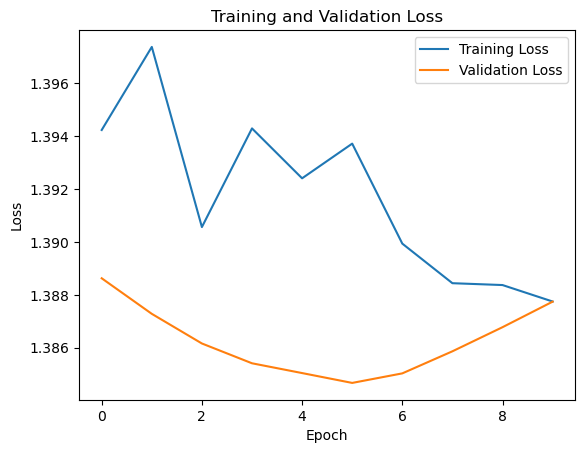

In [39]:
# loss plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [37]:
# compare to validation set
val_values = []
predicted_values = []
    
for visuals, audio_embeds, targets in val_loader:
    visuals, audio_embeds, targets = visuals.to(DEVICE), audio_embeds.to(DEVICE), targets.to(DEVICE)
    visual_embeds = autoencoder.getembedding(visuals).detach()
    outputs = ensemble_model.forward(visual_embeds, audio_embeds).detach()
    # Append the values
    val_values.extend(targets.squeeze().tolist())
    predicted_values.extend(outputs.squeeze().tolist())

am_predicted_values = np.argmax(np.array(predicted_values),1)
am_val_values = np.argmax(np.array(val_values),1)
accuracy = np.sum(am_predicted_values == am_val_values) / len(am_val_values)

In [41]:
predicted_classes, true_classes = [], []
for i in range(len(predicted_values)):
    predicted_values_i = predicted_values[i]
    val_values_1 = val_values[i]

    prediction_prob = torch.nn.functional.softmax((torch.from_numpy(np.array(predicted_values_i))), dim=0)
    predicted_class = prediction_prob.argmax(dim=0).item()
    true_class = np.argmax(np.array(val_values_1))

    print(f'predicted class: {predicted_class}, true class: {true_class}')
    print(f'prediction prob: {prediction_prob}\n\n')

    predicted_classes.append(predicted_class)
    true_classes.append(true_class)

predicted class: 1, true class: 1
prediction prob: tensor([0.2494, 0.2618, 0.2401, 0.2487], dtype=torch.float64)


predicted class: 1, true class: 1
prediction prob: tensor([0.2458, 0.2658, 0.2335, 0.2549], dtype=torch.float64)


predicted class: 1, true class: 1
prediction prob: tensor([0.2561, 0.2593, 0.2371, 0.2475], dtype=torch.float64)


predicted class: 1, true class: 1
prediction prob: tensor([0.2504, 0.2617, 0.2447, 0.2433], dtype=torch.float64)


predicted class: 1, true class: 2
prediction prob: tensor([0.2488, 0.2641, 0.2373, 0.2498], dtype=torch.float64)


predicted class: 1, true class: 2
prediction prob: tensor([0.2567, 0.2620, 0.2419, 0.2394], dtype=torch.float64)


predicted class: 1, true class: 2
prediction prob: tensor([0.2538, 0.2633, 0.2349, 0.2480], dtype=torch.float64)


predicted class: 1, true class: 1
prediction prob: tensor([0.2483, 0.2610, 0.2360, 0.2547], dtype=torch.float64)


predicted class: 0, true class: 3
prediction prob: tensor([0.2570, 0.2559, 0.246

In [42]:
predicted_classes = torch.from_numpy(np.array(predicted_classes))
true_classes = torch.from_numpy(np.array(true_classes))

In [43]:
((predicted_classes == true_classes).sum() / true_classes.shape[0]).item()

0.2800000011920929

In [5]:
from models import TransformerModel_Visual, TransformerModel_Audio, EnsembleModelClassifier

model1 = TransformerModel_Visual(
    d_model = 9216,
    nhead = NUM_HEADS,
    d_hid = HIDDEN_DIM,
    nlayers = NUM_LAYERS
)

model2 = TransformerModel_Audio(
        d_model = 512,
        nhead = NUM_HEADS,
        d_hid = HIDDEN_DIM ,
        nlayers = NUM_LAYERS
    )


ensemble_model = EnsembleModelClassifier(model1,model2)

weights_file = '../models/save/EnsembleModel_classificationi_weights.pt' 
# load check point
ensemble_model.load_state_dict(torch.load(weights_file)['model_state_dict'])

<All keys matched successfully>

In [6]:

EXTRACT_DATA = True # Set whether to run cells that extract data
DATASET = 'video_pack_100_holdout'

if EXTRACT_DATA:
    # extract audio from video dataset
    # extract_audio(f"../data/video_packs/{DATASET}/", f"../data/audio/{DATASET}")

    # using whipser to transcribe audio dialog & extract LLMs embedding
    # extract_embeddings(audio_file_path=f"../data/audio/{DATASET}", output_dir="../data/audio_embeddings/", device=DEVICE, windows_os=True)

    # disable pyav warning
    warnings.filterwarnings("ignore", message="Accurate seek is not implemented for pyav backend")

    # video visual processing
    process_data(
        input_type=DATASET, 
        #addition_parameters={'first_n_videos': 10}, 
        verbose=False,
        device=get_device(),
        frames_to_skip=FRAME_SKIP,
        shrink=SHRINK,
        normalize=NORMALIZE
        )


You are using device: cuda
Processing video visual to tensors..


100%|██████████| 100/100 [07:03<00:00,  4.24s/it]


In [8]:
x_dir, y_dir = get_base_tensor_directories(input_type=DATASET)

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)]) 
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])
# load ensemble data
x_data, y_data = get_ensemble_data(x_files, DATASET)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)

In [9]:
import pandas as pd
import numpy as np

y_train_raw = np.array([i.item() for i in y_train])
y_train_encoded = np.where(
    y_train_raw <= 403.599998,
    0,
    np.where(
        y_train_raw <= 2100.000000,
        1,
        np.where(
            y_train_raw <= 7500.500000,
            2,
            3
        )
    )
)
y_val_raw = np.array([i.item() for i in y_val])
y_val_encoded = np.where(
    y_val_raw <= 403.599998,
    0,
    np.where(
        y_val_raw <= 2100.000000,
        1,
        np.where(
            y_val_raw <= 7500.500000,
            2,
            3
        )
    )
)

y_train_one_hot_encoded2 = np.zeros((y_train_encoded.size, y_train_encoded.max() + 1))
y_train_one_hot_encoded2[np.arange(y_train_encoded.size), y_train_encoded] = 1
y_train_one_hot_encoded2 = torch.from_numpy(y_train_one_hot_encoded2)

y_val_one_hot_encoded2 = np.zeros((y_val_encoded.size, y_val_encoded.max() + 1))
y_val_one_hot_encoded2[np.arange(y_val_encoded.size), y_val_encoded] = 1
y_val_one_hot_encoded2 = torch.from_numpy(y_val_one_hot_encoded2)

In [10]:
train_loader = list(zip(x_train, y_train_one_hot_encoded2))
val_loader = list(zip(x_val, y_val_one_hot_encoded2))
train_loader = DataLoader(train_loader, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch_ensemble)
val_loader = DataLoader(val_loader, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch_ensemble)

print(f'Train set size: {len(x_train)}')
print(f'Val set size: {len(x_val)}')

Train set size: 80
Val set size: 20


In [15]:
import numpy as np

val_values = []
predicted_values = []
    
for visuals, audio_embeds, targets in train_loader:
    visuals, audio_embeds, targets = visuals.to(DEVICE), audio_embeds.to(DEVICE), targets.to(DEVICE)
    visual_embeds = autoencoder.getembedding(visuals).detach()
    outputs = ensemble_model.forward(visual_embeds, audio_embeds).detach()
    # Append the values
    val_values.extend(targets.squeeze().tolist())
    predicted_values.extend(outputs.squeeze().tolist())

for visuals, audio_embeds, targets in val_loader:
    visuals, audio_embeds, targets = visuals.to(DEVICE), audio_embeds.to(DEVICE), targets.to(DEVICE)
    visual_embeds = autoencoder.getembedding(visuals).detach()
    outputs = ensemble_model.forward(visual_embeds, audio_embeds).detach()
    # Append the values
    val_values.extend(targets.squeeze().tolist())
    predicted_values.extend(outputs.squeeze().tolist())


predicted_classes, true_classes = [], []
for i in range(len(predicted_values)):
    predicted_values_i = predicted_values[i]
    val_values_1 = val_values[i]

    prediction_prob = torch.nn.functional.softmax((torch.from_numpy(np.array(predicted_values_i))), dim=0)
    predicted_class = prediction_prob.argmax(dim=0).item()
    true_class = np.argmax(np.array(val_values_1))

    print(f'predicted class: {predicted_class}, true class: {true_class}')
    print(f'prediction prob: {prediction_prob}\n\n')

    predicted_classes.append(predicted_class)
    true_classes.append(true_class)

predicted class: 1, true class: 2
prediction prob: tensor([0.2306, 0.2631, 0.2572, 0.2491], dtype=torch.float64)


predicted class: 2, true class: 1
prediction prob: tensor([0.2205, 0.2321, 0.2989, 0.2485], dtype=torch.float64)


predicted class: 2, true class: 3
prediction prob: tensor([0.2637, 0.2379, 0.2640, 0.2343], dtype=torch.float64)


predicted class: 2, true class: 0
prediction prob: tensor([0.2489, 0.2325, 0.2682, 0.2503], dtype=torch.float64)


predicted class: 2, true class: 3
prediction prob: tensor([0.2324, 0.2440, 0.2665, 0.2571], dtype=torch.float64)


predicted class: 1, true class: 2
prediction prob: tensor([0.2315, 0.2722, 0.2655, 0.2308], dtype=torch.float64)


predicted class: 3, true class: 1
prediction prob: tensor([0.2567, 0.2228, 0.2530, 0.2675], dtype=torch.float64)


predicted class: 1, true class: 2
prediction prob: tensor([0.2484, 0.2591, 0.2405, 0.2520], dtype=torch.float64)


predicted class: 0, true class: 0
prediction prob: tensor([0.2786, 0.2266, 0.261

In [16]:
predicted_classes = torch.from_numpy(np.array(predicted_classes))
true_classes = torch.from_numpy(np.array(true_classes))

In [17]:
((predicted_classes == true_classes).sum() / true_classes.shape[0]).item()

0.23000000417232513